In [1]:
import numpy as np

import pandas as pd
import xarray as xr
import glob

from importlib import reload

""" import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

import cartopy.io.shapereader as shapereader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER """


import scipy.stats as st



In [2]:
import preseason.tools as sf
import preseason.onset_demise as od
import preseason.plotting as pp

In [3]:
### Peru Domain ###
#min_lon = -83+360
#min_lat = -20.0
#max_lon = -67+360
#max_lat = 0.0



### processing CPC data 


cpc_files = glob.glob('/Users/gbromley/data/cpc_uni_global/precip.*.nc')
cpc_raw = xr.open_mfdataset(cpc_files)

### Setting coordinate data for next step 
lat = np.arange(-90, 90, 0.5)
lon = np.arange(0, 360, 0.5)
time = cpc_raw['time'].data

### transposing dimensions so the world is right side up 

flipped_cpc = np.flip(cpc_raw['precip'].values, axis=1)
### cpc latitudes are reversed so that they are decreasing instead of increasing. The following code reverses it. 
cpc_pr = xr.DataArray(flipped_cpc, coords=[('time', time), ('lat', lat), ('lon', lon)], name='precipitation')

#TODO create xml of location definitions
### Selecting out Peru from the global data.
PERU = {'lat': slice(-20,0), 'lon': slice(360-83, 360-67)}
cpc_conus = cpc_pr.sel(lat = PERU['lat'], lon = PERU['lon'])

In [4]:
bom_onset_avg = xr.open_dataset('/Users/gbromley/data/CPC_OD/mean.onset.wet.season.CPC_UNI.nc', decode_cf = False)
bom_onset_avg = bom_onset_avg['avgons'].sel(PERU).squeeze()
bom_onset_avg = xr.where(bom_onset_avg == -999., np.nan, bom_onset_avg)


In [5]:
bom_demise_avg = xr.open_dataset('/Users/gbromley/data/CPC_OD/mean.end.wet.season.CPC_UNI.nc', decode_cf = False)
bom_demise_avg = bom_demise_avg['avgdem'].sel(PERU).squeeze()
bom_demise_avg = xr.where(bom_demise_avg == -999., np.nan, bom_demise_avg)

In [6]:
#Load the yearly bombardi estimates

bom_onset_files = glob.glob('/Users/gbromley/data/CPC_OD/onset.wet.season.CPC_UNI.*.nc')
bom_onset_ts = xr.open_mfdataset(sorted(bom_onset_files), decode_cf = False, combine = 'nested', concat_dim='time')
bom_onset_ts = bom_onset_ts['DOY'].sel(PERU).squeeze()
bom_onset_ts = xr.where(bom_onset_ts == -999., np.nan, bom_onset_ts)

bom_onset_ts['time'] = pd.date_range('1979', freq='YS', periods = len(bom_onset_ts['time'].values))
bom_onset_ts = bom_onset_ts.sel(time=slice('1980','2010'))
bom_onset_ts = bom_onset_ts.assign_coords({'year':bom_onset_ts['time']})
bom_onset_ts = bom_onset_ts.swap_dims({"time": "year"})
bom_onset_ts = bom_onset_ts.compute()

In [7]:
bom_demise_files = glob.glob('/Users/gbromley/data/CPC_OD/demise.wet.season.CPC_UNI.*.nc')
bom_demise_ts = xr.open_mfdataset(sorted(bom_demise_files), decode_cf = False, combine = 'nested', concat_dim='time')
bom_demise_ts= bom_demise_ts['DOY'].sel(PERU).squeeze()
bom_demise_ts = xr.where(bom_demise_ts == -999., np.nan, bom_demise_ts)

#pd.date_range('1979', freq='YS', periods = 42)

bom_demise_ts['time'] = pd.date_range('1979', freq='YS', periods = len(bom_demise_ts['time'].values))
bom_demise_ts = bom_demise_ts.sel(time=slice('1980','2010'))
bom_demise_ts = bom_demise_ts.assign_coords({'year':bom_demise_ts['time']})
bom_demise_ts = bom_demise_ts.swap_dims({"time": "year"})
bom_demise_ts = bom_demise_ts.compute()

In [8]:
### Only needed if we are recalculating onset/demise
cpc_conus_anom = cpc_conus - cpc_conus.mean(dim='time')

annual_cycle = sf.calc_annual_cycle(cpc_conus)
start_wet = od.B17_analysis_start(annual_cycle)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
#onset = od.onset_B17(cpc_conus_anom, startWet=start_wet)
onset = xr.open_dataarray('OnsetPeru_CPCUNI.nc')
onset = onset.sel(year=slice('1980','2010'))

In [10]:
#demise = od.demise_B17(cpc_conus_anom, startWet=start_wet)
demise = xr.open_dataarray('DemisePeru_CPCUNI.nc')
demise = demise.sel(year=slice('1980','2010'))

In [11]:
#onset.to_netcdf('OnsetPeru_CPCUNI.nc')

In [12]:
#demise.to_netcdf('DemisePeru_CPCUNI.nc')

In [13]:
###TODO Need to put this into a function
onset_dates_bom = sf.calcDates(bom_onset_ts)
onset_dates = sf.calcDates(onset)
date_diff = (onset_dates - onset_dates_bom)
days_diff_onset = date_diff / np.timedelta64(1, "D")

/Users/gbromley/opt/anaconda3/envs/preseason/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/gbromley/opt/anaconda3/envs/preseason/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


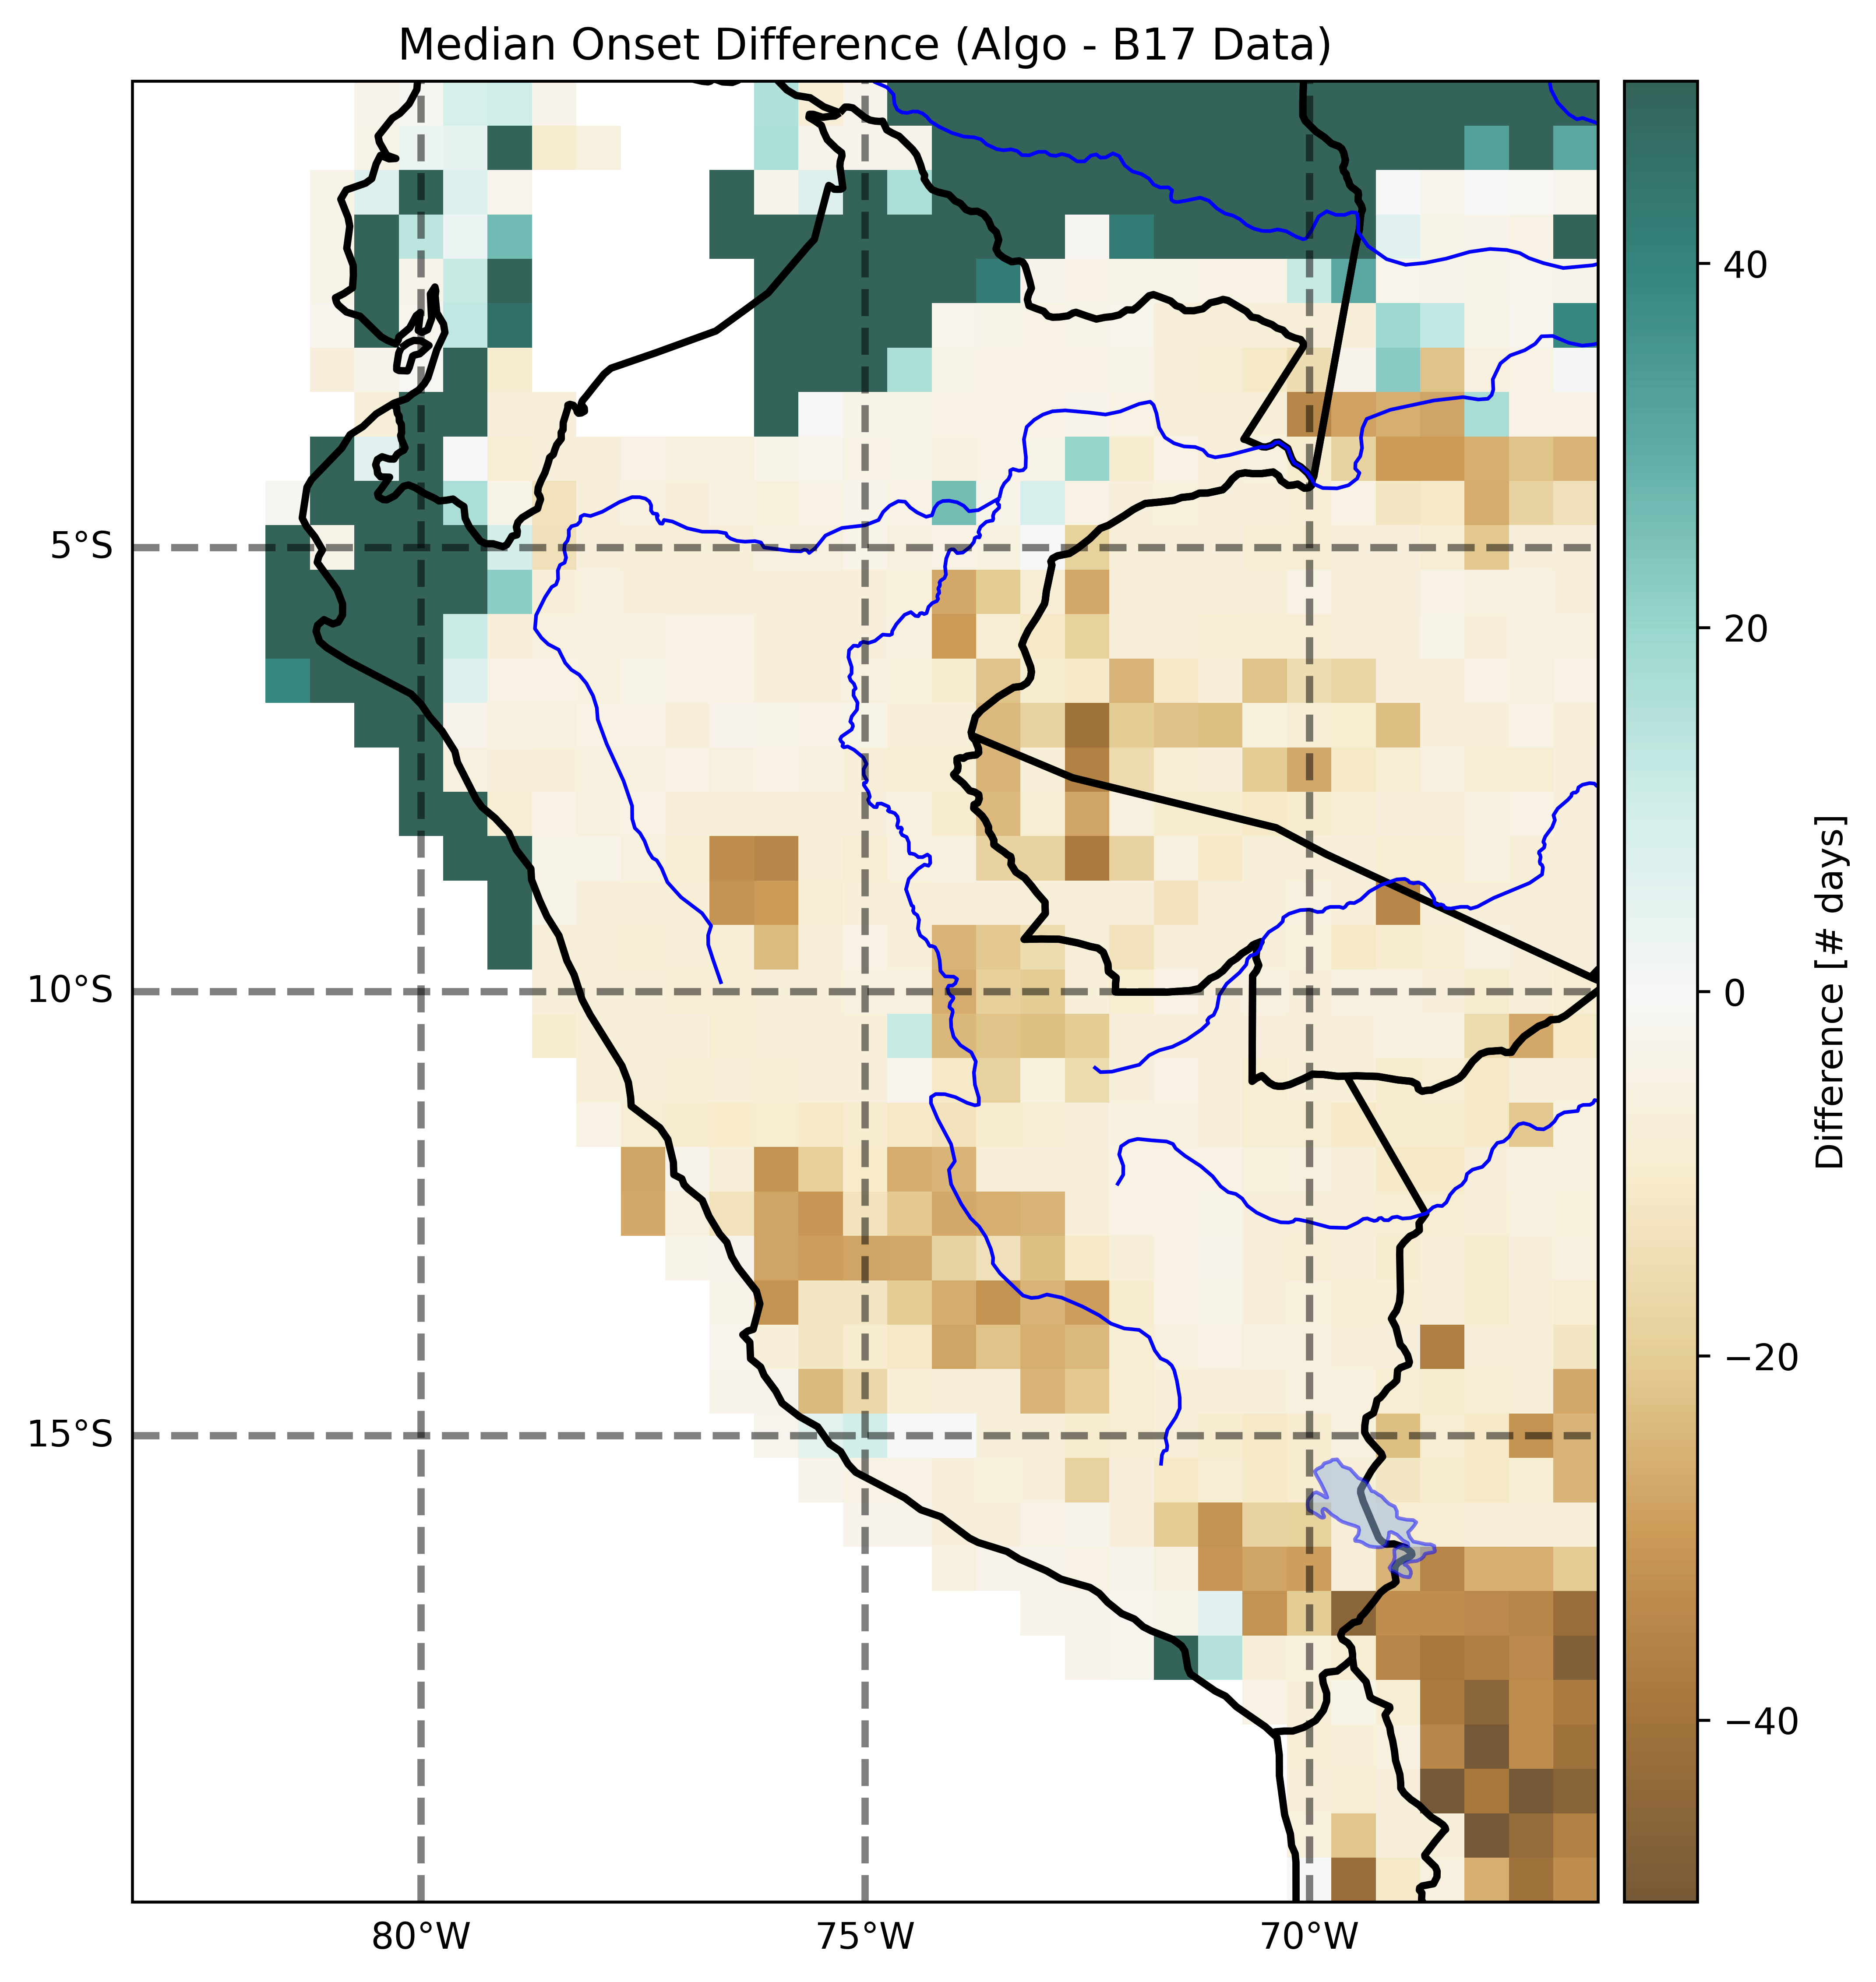

In [14]:
pp.plot_spatial_data(days_diff_onset.median(dim='year'), vmin=-50, vmax=50, cmap='BrBG', title='Median Onset Difference (Algo - B17 Data)', var = 'Difference [# days]')

In [15]:
demise_dates_bom = sf.calcDates(bom_demise_ts)
demise_dates = sf.calcDates(demise)
date_diff_demise = (demise_dates - demise_dates_bom)
days_diff_demise = date_diff_demise / np.timedelta64(1, "D")

/Users/gbromley/opt/anaconda3/envs/preseason/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/gbromley/opt/anaconda3/envs/preseason/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


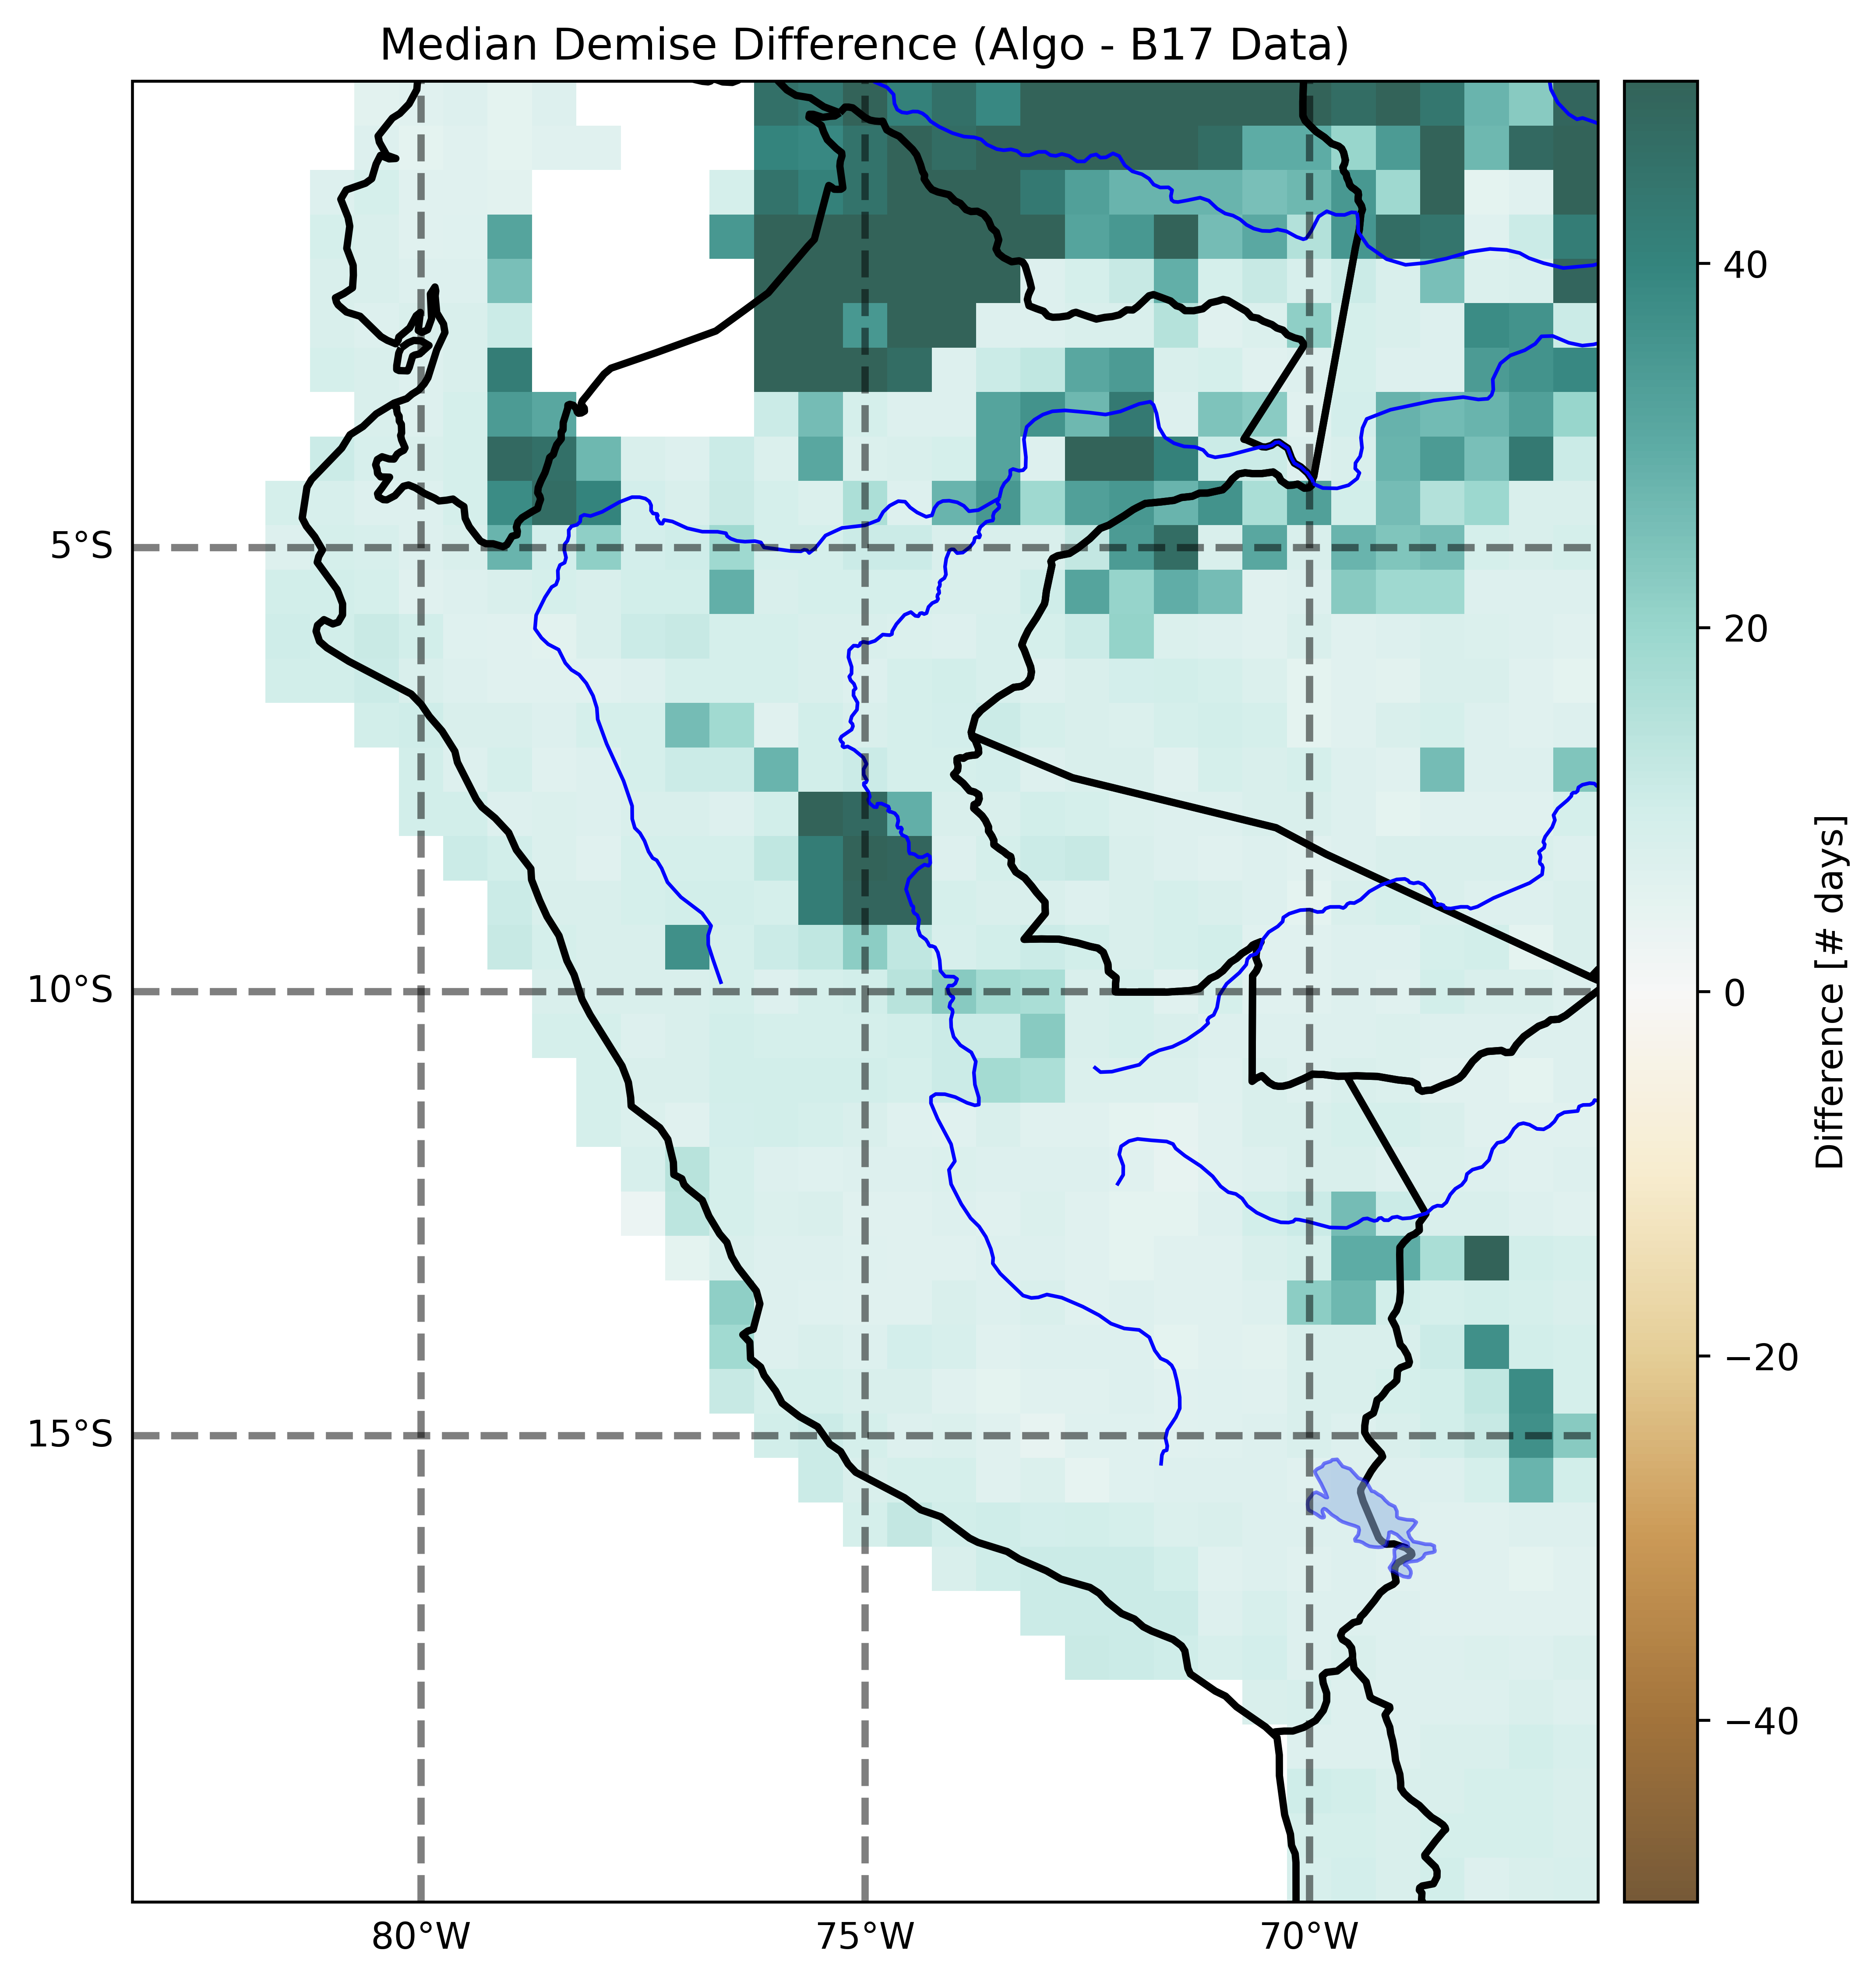

In [16]:
pp.plot_spatial_data(days_diff_demise.median(dim='year'), vmin=-50, vmax=50, cmap='BrBG', title='Median Demise Difference (Algo - B17 Data)', var = 'Difference [# days]')